# Эталонное сравнение

In [36]:
import opendatasets as od
import pandas
import numpy as np
import json
from heapq import heappop, heappush,heappushpop
import matplotlib.pyplot as plt

import time
# od.download(
# 	"https://www.kaggle.com/datasets/zalando-research/fashionmnist/data")

In [40]:
def distance(a, b):
    temp = a - b
    return np.sqrt(sum(temp**2))

# Fixed size priority queue (max heap) realization
# h - reversed array, so actual answer will be -h.
# k - size of priority queue
def push(h, distance, index, k):
    item = (-1 * distance, index)
    if (len(h) < k):
        heappush(h, item)
    else:
        heappushpop(h, item)
    
# Return k nearest vectors for given vector from ds.
# D - array with distances, I - array with indexes.
def get_nearest(k, vector, ds):
    h = []
    for i in range(len(vectors)):
        push(h, distance(vector, ds.iloc[i]), i, k)
    # Distances in ascending order 
    h.sort(reverse=True)
    D = []
    I = []
    for i in range(len(h)):
    # Reverse distance value to make it normal (it was reversed in push for max heap realization)
        D.append(-h[i][0])
        I.append(h[i][1])
    return (D, I)

def write_in_json(ind_to_find, D, I, k, filename):
    to_write = {
        "k": k,
        "ind_to_find": ind_to_find,
        "distances": D,
        "indexes": I
    }
    with open(filename, "w") as outfile:
        json.dump(to_write, outfile)

def find_nearest(k, ind_to_find, vectors, exp_name):
    print(f"{exp_name}: k = {k}, index_to_find = {ind_to_find}")
    D, I = get_nearest(k, vectors.iloc[ind_to_find], vectors)
    write_in_json(ind_to_find, D, I, k, "experiments/" + exp_name + '.json')

In [33]:
mnist = pandas.read_csv("./fashionmnist/fashion-mnist_train.csv")
vectors = mnist.drop(columns='label')

In [15]:
indexes = [10, 50, 100, 1000, 2000, 3000, 4000, 10000, 20000]

In [41]:
k = 16
# Мерим время вместе с записью результатов в json, 
# но время записи не существенно (поскольку сам поиск занимает больше 10 секунд)
for ind in indexes:
    %time find_nearest(k, ind, vectors, 'exp' + str(ind))    

exp10: k = 16, index_to_find = 10
CPU times: user 16.4 s, sys: 113 ms, total: 16.5 s
Wall time: 16.6 s
exp1000: k = 16, index_to_find = 1000
CPU times: user 16.3 s, sys: 78.2 ms, total: 16.4 s
Wall time: 16.4 s
exp10000: k = 16, index_to_find = 10000
CPU times: user 16.3 s, sys: 71.2 ms, total: 16.4 s
Wall time: 16.4 s
exp20000: k = 16, index_to_find = 20000
CPU times: user 15.8 s, sys: 85.3 ms, total: 15.8 s
Wall time: 15.9 s


# Faiss

In [138]:
# https://faiss.ai/index.html
# conda install -c conda-forge faiss-cpu
# https://github.com/facebookresearch/faiss/wiki/Faiss-indexes - типы индексов 

In [25]:
def compare_with_ideal(I_ideal, indexes_to_find, index, k):
    D, I = index.search(vectors.iloc[indexes_to_find], k)
    # Посчитаем точность
    sum_accuracy = 0
    for i in range(len(indexes)):
        matched = set(I_ideal[i]).intersection(set(I[i]))
        accuracy = len(matched) / k
        print(f'find nearest with {indexes_to_find[i]}, accuracy: {len(matched) / k}')
        sum_accuracy += accuracy
    avg_accuracy = sum_accuracy / len(indexes)
    print(f'avg accuracy: {sum_accuracy / len(indexes)}')

    return avg_accuracy

In [17]:
import numpy as np
import faiss                  # make faiss available

mnist = pandas.read_csv("./fashionmnist/fashion-mnist_train.csv")
vectors = mnist.drop(columns='label')
d = vectors.shape[1]
k = 16

index_basic = faiss.IndexFlatL2(d)   # build the index
print(index_basic.is_trained)
index_basic.add(vectors)
print(index_basic.ntotal)


True
60000


In [18]:
print(f'indexes for which we find neighbors: {indexes}')
%time D_ideal, I_ideal = index_basic.search(vectors.iloc[indexes], k)

indexes for which we find neighbors: [10, 50, 100, 1000, 2000, 3000, 4000, 10000, 20000]
CPU times: user 128 ms, sys: 2.91 ms, total: 131 ms
Wall time: 15.4 ms


#Inverted file index
Разбиение на кластеры и пересчет внутри кластера.

In [19]:
def create_ivf_index(clusters_count, d, vectors):
    quantiser = faiss.IndexFlatL2(d)
    index_ivf = faiss.IndexIVFFlat(quantiser, d, clusters_count)
    index_ivf.train(vectors) 
    index_ivf.add(vectors)
    return index_ivf

In [39]:
clusters_n_arr = [5, 10, 50, 100, 200, 350, 500, 1000, 2000]
accuracy_arr = []
times_ms = [] 
for clusters_count in clusters_n_arr:
    print(f'ivf with clusters count {clusters_count}')
    ivf = create_ivf_index(clusters_count, d, vectors)
    start = time.perf_counter_ns()
    accur = compare_with_ideal(I_ideal, indexes, ivf, k)
    times_ms.append((time.perf_counter_ns() - start) / 1e6)
    accuracy_arr.append(accur)
    print()



ivf with clusters count 5
find nearest with 10, accuracy: 1.0
find nearest with 50, accuracy: 1.0
find nearest with 100, accuracy: 1.0
find nearest with 1000, accuracy: 1.0
find nearest with 2000, accuracy: 0.625
find nearest with 3000, accuracy: 1.0
find nearest with 4000, accuracy: 1.0
find nearest with 10000, accuracy: 0.875
find nearest with 20000, accuracy: 1.0
avg accuracy: 0.9444444444444444

ivf with clusters count 10
find nearest with 10, accuracy: 1.0
find nearest with 50, accuracy: 0.875
find nearest with 100, accuracy: 1.0
find nearest with 1000, accuracy: 0.375
find nearest with 2000, accuracy: 1.0
find nearest with 3000, accuracy: 1.0
find nearest with 4000, accuracy: 1.0
find nearest with 10000, accuracy: 0.875
find nearest with 20000, accuracy: 1.0
avg accuracy: 0.9027777777777778

ivf with clusters count 50
find nearest with 10, accuracy: 1.0
find nearest with 50, accuracy: 0.4375
find nearest with 100, accuracy: 0.75
find nearest with 1000, accuracy: 0.1875
find neare

WARNING clustering 60000 points to 2000 centroids: please provide at least 78000 training points


find nearest with 10, accuracy: 0.75
find nearest with 50, accuracy: 0.25
find nearest with 100, accuracy: 0.4375
find nearest with 1000, accuracy: 0.8125
find nearest with 2000, accuracy: 0.9375
find nearest with 3000, accuracy: 0.5
find nearest with 4000, accuracy: 0.25
find nearest with 10000, accuracy: 0.3125
find nearest with 20000, accuracy: 0.4375
avg accuracy: 0.5208333333333334



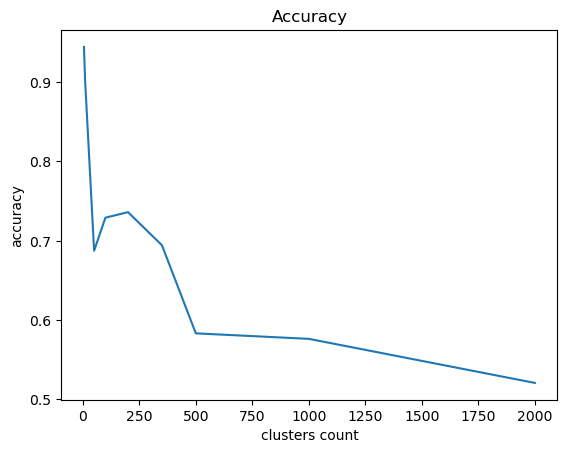

In [40]:
plt.plot(clusters_n_arr, accuracy_arr)
plt.xlabel('clusters count')
plt.ylabel('accuracy')
plt.title('Accuracy')
 
# function to show the plot
plt.show()

In [ ]:
plt.plot(clusters_n_arr, accuracy_arr)
plt.xlabel('clusters count')
plt.ylabel('accuracy')
plt.title('Accuracy')
 
# function to show the plot
plt.show()